In [11]:
import os
os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic")

import numpy as np
from matplotlib import pyplot as plt
import h5py

from dynapseReservoir.networks.dynapseParameters import dynapseStructure
from dynapseReservoir.networks.reservoirsParameters import generalNetP, r64_1_1_P
from dynapseReservoir.networks.outputParameters import generalOutP
import DYNAPSETools.dynapseOutDecoder as DOD


plt.close("all")


folderName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myoutputs/thesis_output_aedat/classification/"

 

Read all data

Extracted 6 experiments


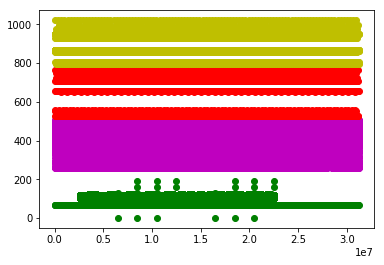

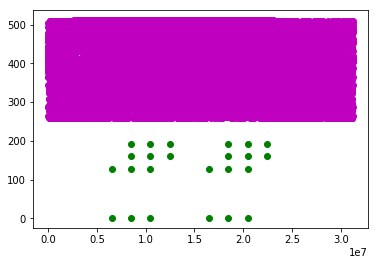

In [21]:

# experimentName = 'baselineBias_classificationRes_classification'


# experimentName = 'classification_baseline_test'

experimentName = 'classification_tuned_test'

# experimentName = 'classificationBias_slowClassificationRes_classification'

inputRecording = experimentName + '.aedat'

outputDataset = experimentName + '.hdf5'

fileName =  os.path.join(folderName, inputRecording)



# inputRecordings =  os.path.join(folderName, inputRecording)

#inputRecordings = ["out_train_1_0_reservoir_r64_1_2.aedat"]
#outputDatasets = ["slowExTest.hdf5"]
#outputDatasets = ["noReservoir.hdf5"]

#outputDatasets = ["noReservoirTest.hdf5"]





# ===============================================================================
# ===============================================================================
# ===============================================================================
# ====================== Import .AEDAT file
#fileName =  os.path.join(folderName, inputRecording)
# fileName = inputRecordings
decEvents = DOD.import_events(fileName)
decEvents = decEvents.normalize()
decEvents.plot_events()

# ====================== Define Filter events Core 0
filterCore0 = []
size = generalNetP["sizeTargetEncoding"] # WHAT IS sizeTargetEncoding??
U0, C0, N = generalNetP["targetEncodingPos"]
targetNeurons = [x for x in range(N, size + N)]
filterCore0 += targetNeurons

# Filter events taking only events that are important for elaboration
U0, C0, N1 = generalNetP["startTriggerPos"]
U0, C0, N2 = generalNetP["stopTriggerPos"]
U0, C0, N3 = generalNetP["endStimulusPos"]
filterCore0 += [N1, N2, N3]

# ====================== Define Filter events Core 1
#%%
size = r64_1_1_P["N_Res"]
U0, C1, N = generalNetP["reservoirStartPos"]
filterCore1 = [x for x in range(N, size + N)]


# ====================== Apply filter
neuron_id_filter = [filterCore0, filterCore1]
decFilteredEvents = decEvents.filter_events(chip_id = U0, core_id = [C0, C1], neuron_id = neuron_id_filter) # Take only events i need
decFilteredEvents.plot_events()

# ====================== Extract experiments
extractedEvents = decFilteredEvents.isolate_events_sets(startTriggerNeuron = generalNetP["startTriggerPos"],
                                                        stopTriggerNeuron = generalNetP["stopTriggerPos"],
                                                        maxNumber = None)

# ====================== Extract output target values for dataset creation
# Each target value is a number that represent the number of the neuron that has to fire to classify correctly
#                  Experiment 1     Experiment 2     ...     Experiment n
# Target value     1                2                ...     5
targetValues = []
for experiment in extractedEvents:
    filteredEvents = experiment.filter_events(chip_id = U0, core_id = C0, neuron_id = None) # Take only settings events
    # Check if one of the target neurons is present inside the pattern and insert in output list
    # PAY ATTENTION TO DON'T MAKE TARGET NEURONS FIRE WHEN IT'S NOT THEIR TIME
    for targetNeuron in targetNeurons:
        if targetNeuron in filteredEvents.neuron_id:
            targetValues.append(targetNeuron)
            break

# Reshape to have horizontal values
targetValues = np.reshape(np.array(targetValues), (1, -1))
    
# Plot every event set in the list
# DOD.plot_events(extractedEvents)

#%% Calculate the matrix of spike induced currents

totNeurons = dynapseStructure["nNeuronsPerChip"]
experiment = extractedEvents[0] # try a single experiment
#timeBin = generalOutP["timeBin"] # 0.1 second
alpha = 0.04


U, C, N = generalNetP["reservoirStartPos"]
startNeuronRes = dynapseStructure["nNeuronsPerCore"] * C + N
stopNeuronRes = startNeuronRes + r64_1_1_P["N_Res"]



sicMatrices = []

for experiment in extractedEvents:
    spikeInducedCurrent_allNeurons = experiment.calculate_sic_matrix(totNeurons, alpha, timeBin = generalOutP["timeBin"]*0.1)
    spikeInducedCurrentMat =  np.array(spikeInducedCurrent_allNeurons[startNeuronRes:stopNeuronRes])
    sicMatrices.append(spikeInducedCurrentMat)
    
    


#%%
#data = firingRateMatrixes
data = sicMatrices


# ====================== Create targets of dataset
outNotFiring = generalOutP["outNotFiring"]
outFiring = 1
outNeurons = r64_1_1_P["N_out"]

# Every target has shape (k, l) where l depends on the time length of matrix
# k is the number of output neurons i'm considering
#   Target 0
# 1 xxxxxxxx
# 2 xxxxxxxx
# ...
# k xxxxxxxx

# final target array will be like this, with shape (n, k, l)
#   Target 0    Target 1 ... Target n
# 1 xxxxxxxx    xxxxxxxx     xxxxxxxx
# 2 xxxxxxxx    xxxxxxxx     xxxxxxxx
# ...
# k xxxxxxxx    xxxxxxxx     xxxxxxxx


In [22]:
target = []

# Transform the target value encoding in actual target firing rates
for idx, value in enumerate(targetValues[0]):
    # Create a matrix of not firing neurons
    matrix = np.ones((outNeurons, np.shape(data[idx])[1])) * outNotFiring
    # Make fire only the out neuron that has to fire, according to target value
    matrix[value - 1] = outFiring
    target.append(matrix)
    
allTarget = np.concatenate((target[0], target[1], target[2],target[3],target[4],target[5]), axis = 1)
allData = np.concatenate((data[0], data[1], data[2],data[3],data[4],data[5]), axis = 1)


In [23]:
# target = np.array(target)

#%%
# ====================== Create dataset
fileName = os.path.join(folderName, outputDataset)
h5f = h5py.File(fileName, "w")
dset = h5f.create_dataset("data", np.shape(allData), dtype = "f")
dset[...] = allData
dset = h5f.create_dataset("target", np.shape(allTarget), dtype = "f")
dset[...] = allTarget
h5f.close()